In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
import math
import types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from scipy import stats, spatial, optimize
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.multivariate.manova import MANOVA
from sklearn.decomposition import PCA
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
## LOAD MANUAL AND AUTOMATIC IQMs

code_path = "/data/code/DefacingProject"
data_path = "/data/derivatives/mriqc/RoyalCarpetPlot/DefacingPilotData/shuffled"
manualQCpathCP = "/data/code/DefacingProject/pilot_study/ManualRatings/Celine"
manualQCpathOE = "/data/code/DefacingProject/pilot_study/ManualRatings/Oscar"

with open(os.path.join(code_path,"randomization","DefacingPilotData_blind_dict.json")) as json_file:
    blind_dict = json.load(json_file)
with open(os.path.join(code_path,"randomization","DefacingPilotData_pos_dict.json")) as json_file:
    pos_dict = json.load(json_file)

def get_key(my_dict,val):
    for key, value in my_dict.items():
         if val == value:
             return key
        
df_api = pd.read_pickle('./MRIQC_API_T1w/T1w_siemens_prisma')
df_api.drop('summary_bg_p05', axis=1, inplace=True)
df_api = df_api.reindex(sorted(df_api.columns), axis=1)
api = df_api.to_numpy()

manual_original = np.zeros((10,2))
manual_defaced = np.zeros((10,2))  
iqms_original = np.zeros((10,61))
iqms_defaced = np.zeros((10,61))
for s in range(0,20):
    with open(os.path.join(manualQCpathCP,"_unset__sub-{}_ses-V1_run-1_T1w.json".format(s))) as json_file:
        scoreCP = json.load(json_file)
    with open(os.path.join(manualQCpathOE,"unset__sub-{}_ses-V1_run-1_T1w.json".format(s))) as json_file:
        scoreOE = json.load(json_file)
    with open(os.path.join(data_path, 'sub-{}'.format(s), "ses-V1", "anat","sub-{}_ses-V1_run-1_T1w.json".format(s))) as json_file:
        iqms = json.load(json_file)
        iqms_keys = list(iqms.keys())
        iqms_keys.remove('bids_meta')
        iqms_keys.remove('provenance')
        iqms_keys.remove('size_x')
        iqms_keys.remove('size_y')
        iqms_keys.remove('size_z')
        iqms_keys.remove('spacing_x')
        iqms_keys.remove('spacing_y')
        iqms_keys.remove('spacing_z')
        iqms_keys.remove('summary_bg_p05')
        
    assert len(df_api.columns) == len(iqms_keys), 'There is not the same nbr of iqms in the API based and in this dataset'

    sub = get_key(blind_dict,s)
    pos = int(get_key(pos_dict,sub[0:8]))

    if "non_deface" in sub:
        # Manual quality rating
        manual_original[pos,0] = scoreCP['rating']
        manual_original[pos,1] = scoreOE['rating']
        # Automatic quality metrics
        for i,key in enumerate(iqms_keys):
            iqms_original[pos,i] = iqms[key]
    elif "pydeface" in sub:
        # Manual quality rating
        manual_defaced[pos,0] = scoreCP['rating']
        manual_defaced[pos,1] = scoreOE['rating']
        # Automatic quality metrics
        for i,key in enumerate(iqms_keys):
            iqms_defaced[pos,i] = iqms[key]
    else:
        raise ValueError("{} is an invalid name".format(sub)) 

FileNotFoundError: [Errno 2] No such file or directory: '/data/code/DefacingProject/ManualRatings/Celine/_unset__sub-0_ses-V1_run-1_T1w.json'

In [4]:
print(len(iqms_keys))

61


##  BLAND-ALTMAN PLOT manual rating

[3.5 2.5 3.5 2.5 3.5 2.5 3.5 3.  2.  3. ]
[-1.  1. -1. -1. -1. -1. -1.  0.  0.  0.]
[3.  2.  2.5 2.5 3.  2.5 3.  2.5 1.  2. ]
[ 0.  0. -1. -1.  0. -1.  0. -1.  0.  0.]


Text(0.02, 0.5, 'Rating on original image - Rating on defaced image')

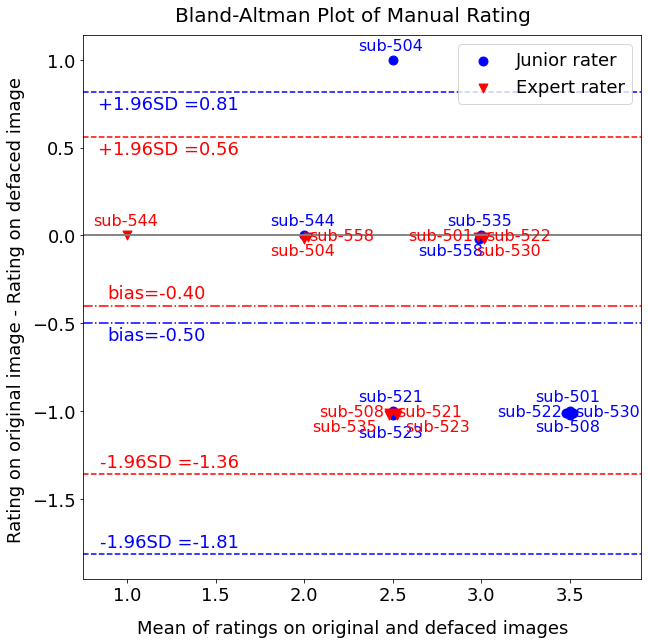

In [19]:
%matplotlib inline
def bland_altman_plot_m(data1,data2,data_label, ax, fontsize, pos_dict=None, color = 'b', marker = 'o', jitter = None):
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)  # Standard deviation of the difference
    print(mean)
    print(diff)
    if jitter is not None:
        for i in range(0,mean.size):
            mean[i]+=jitter[i][0]*0.02
            diff[i]+=jitter[i][1]*0.02
    
    ax.scatter(mean, diff, color=color, label = data_label, marker = marker, s=80)
    ax.axhline(0, color='gray', linestyle='-')
    ax.axhline(md, color=color, linestyle='-.')
    ax.axhline(md + 1.96*sd, color=color, linestyle='--')
    ax.axhline(md - 1.96*sd, color=color, linestyle='--')
    ax.tick_params(labelsize=fontsize)
    ax.ticklabel_format(axis='y', style='scientific',scilimits=(-1,1))
    ax.yaxis.offsetText.set_fontsize(fontsize-2)
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    if color == 'r':
        ax.text(0.22, md + 0.02, 'bias={:.2f}'.format(md), transform=trans, fontsize=fontsize,
            verticalalignment='bottom', horizontalalignment='right', color=color)
    else:
        ax.text(0.22, md - 0.12, 'bias={:.2f}'.format(md), transform=trans, fontsize=fontsize,
            verticalalignment='bottom', horizontalalignment='right', color=color)
        
    ax.text(0.28, md + 1.96*sd - 0.12, '+1.96SD ={:.2f}'.format(md+1.96*sd), transform=trans, fontsize=fontsize,
        verticalalignment='bottom', horizontalalignment='right', color=color)
    ax.text(0.28, md - 1.96*sd + 0.12, '-1.96SD ={:.2f}'.format(md-1.96*sd), transform=trans, fontsize=fontsize,
        verticalalignment='top', horizontalalignment='right', color=color)

    if pos_dict is not None:
        for i in range(0, mean.size):
            ax.text(mean[i]-0.01+jitter[i][0]*0.2, diff[i]+0.04+jitter[i][1]*0.15, 'sub-{}'.format(pos_dict[str(i)][-3:]), fontsize=fontsize-2,
                verticalalignment='bottom', horizontalalignment='center', color=color)
            #ax.text(mean[i]-0.01+jitter[i][0]*0.2, diff[i]+0.04+jitter[i][1]*0.15, 'sub-{}'.format(i+1), fontsize=fontsize-2,
                #verticalalignment='bottom', horizontalalignment='center', color=color)

# MANUAL RATING PLOT
fig, ax = plt.subplots(1,sharex=False,sharey=False,figsize=(10,10))
fig.suptitle('Bland-Altman Plot of Manual Rating',fontsize=20, y=0.92)

jitterCP = [(0,0), (0,0), (0,-1), (0,0), (-1,-0.5), (0,-1.2), (1,-0.5), (0,0), (0,0), (-0.75,-1)]
jitterOE = [(-1,-0.5), (0,-1), (-1,-0.5), (1,-0.5), (1,-0.5), (1.2,-1), (0.75,-1), (-1.2,-1), (0,0), (1,-0.5)]
bland_altman_plot_m(manual_original[:,0], manual_defaced[:,0], 'Junior rater', ax, pos_dict=pos_dict, \
                  fontsize = 18, color = 'b', marker = 'o', jitter = jitterCP)
bland_altman_plot_m(manual_original[:,1], manual_defaced[:,1], 'Expert rater', ax, pos_dict=pos_dict, \
                  fontsize = 18, color = 'r', marker = 'v', jitter = jitterOE)
ax.legend(loc='upper right',fontsize = 18)
ax.set_xlim([0.75,3.9])

fig.text(0.5, 0.05, 'Mean of ratings on original and defaced images', fontsize = 18, ha='center')
fig.text(0.02, 0.5, 'Rating on original image - Rating on defaced image', fontsize = 18, va='center', rotation='vertical')

# Chi-squared test - Manual rating

In [5]:
from scipy.stats import chi2_contingency

#alternative for repeated measures = statsmodels.stats.contingency_tables.SquareTable.homogeneity
# need to construct the contingency table differently https://peterstatistics.com/CrashCourse/4-TwoVarPair/NomNom/NomNomPair3.html
def test_manual(man_ori, man_def):
    # defining the frequency distribution table
    counts_original = np.bincount(man_ori.astype(int))
    counts_defaced = np.bincount(man_def.astype(int))
    while(len(counts_original)) < 5:
        # pad the counts if not all score from 1 to 4 has been assigned
        counts_original = np.append(counts_original, 0)
        
    contingency_table = np.vstack((counts_original[1:], counts_defaced[1:])).T
    print(contingency_table)
    # is the quality score related to the category with or without face
    stat, p, dof, expected = chi2_contingency(contingency_table)
    print(p)
    print(p<0.05)
    
#test for CP
test_manual(manual_original[:,0], manual_defaced[:,0])
#test for OE
test_manual(manual_original[:,1], manual_defaced[:,1])

[[0 0]
 [3 2]
 [7 4]
 [0 4]]


ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

##  BLAND-ALTMAN PLOT IQMs - ALL

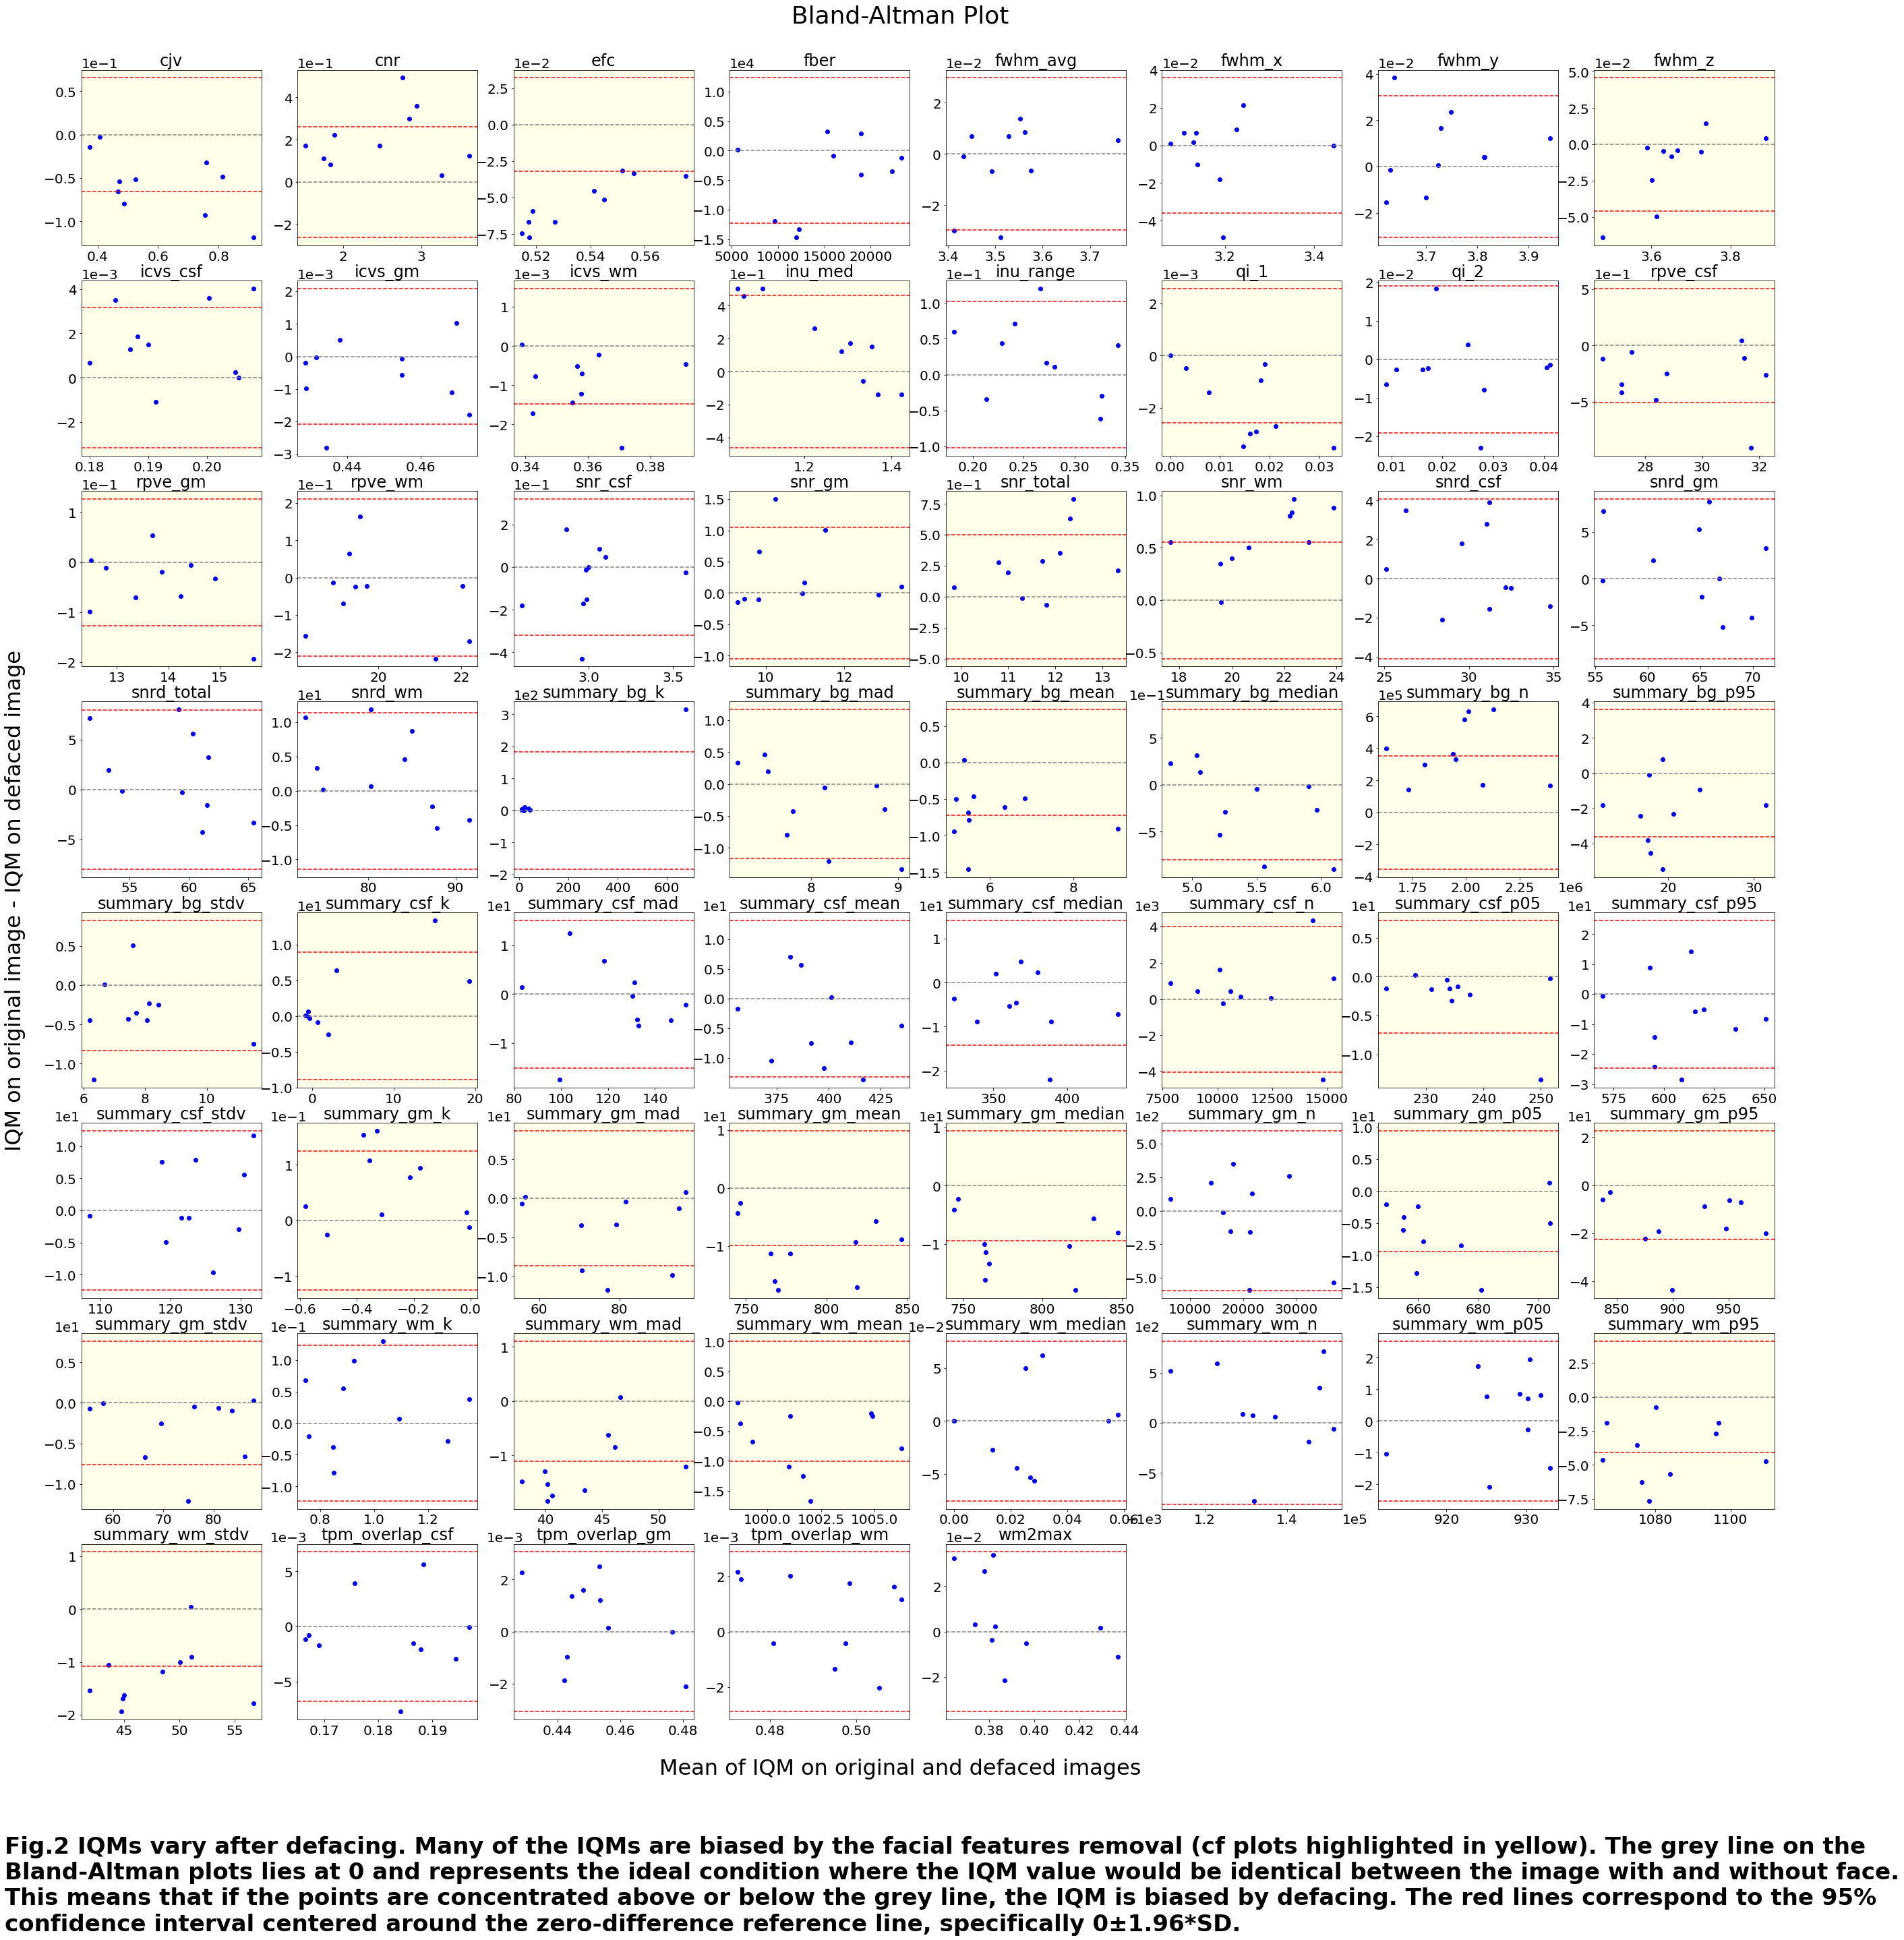

In [3]:
%matplotlib inline
def bland_altman_plot_i(data1,data2,data_label, ax, fontsize, offsety=0,\
                        offsetx=1, facecolor=(1.0, 1.0, 1.0, 1.0)):
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = 0 #np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)  # Standard deviation of the difference
    
    ax.scatter(mean, diff, color = 'b')
    ax.set_title(data_label,fontsize = fontsize+2)
    ax.axhline(md, color='gray', linestyle='--')
    ax.axhline(md + 1.96*sd, color='red', linestyle='--')
    ax.axhline(md - 1.96*sd, color='red', linestyle='--')
    ax.tick_params(labelsize=fontsize-2)
    ax.set_facecolor(facecolor)
    
    # Scientific notation of yaxis
    ax.ticklabel_format(axis='y', style='scientific',scilimits=(-1,1))
    ax.yaxis.offsetText.set_fontsize(fontsize-2)
    ty = ax.yaxis.get_offset_text()
    ty.set_x(offsety)
    ax.ticklabel_format(axis='x', style='scientific',scilimits=(-5,5))
    ax.xaxis.offsetText.set_fontsize(fontsize-2)
    #Scientific notation of xaxis
    pad = plt.rcParams["xtick.major.size"] + plt.rcParams["xtick.major.pad"]
    def bottom_offset(self, bboxes, bboxes2):
        bottom = self.axes.bbox.ymin
        self.offsetText.set(va="top", ha="left") 
        oy = bottom - pad * self.figure.dpi / 72.0
        self.offsetText.set_position((1, oy))

    ax.xaxis._update_offset_text_position = types.MethodType(bottom_offset, ax.xaxis)
    
# IQMS PLOT
fig, axs = plt.subplots(8,8,sharex=False,sharey=False,figsize=(45,45))
fig.suptitle('Bland-Altman Plot',fontsize=36, y = 0.91)
axs[7,5].set_axis_off()
axs[7,6].set_axis_off()
axs[7,7].set_axis_off()

offsety = np.zeros((len(iqms_keys),1))
offsetx = np.ones((len(iqms_keys),1))
facecolor = [axs[0,0].get_facecolor() for i in range(len(iqms_keys))]
for i,key in enumerate(iqms_keys):
    if i in [34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,53,57,58,59]:
        offsety[i] = -0.15
    if i ==29:
        offsety[i] = -0.18
    if i ==52:
        offsety[i] = -0.21
        offsetx[i] = 1.05
        
    if i in [0,1,2,7,8,10,11,13,15,16,19,20,21,27,28,29,30,31,32,33,37,38,41,42,43,44,46,47,48,50,51,55,56]:
        facecolor[i] = (1, 1, 0.6 , 0.2)
        
    bland_altman_plot_i(iqms_original[:,i], iqms_defaced[:,i], key, axs[i//8,i%8], fontsize = 22, \
                        offsety=offsety[i], offsetx=[i], facecolor = facecolor[i] )

fig.text(0.5, 0.1, 'Mean of IQM on original and defaced images', fontsize = 32, ha='center')
fig.text(0.09, 0.5, 'IQM on original image - IQM on defaced image', fontsize = 32, va='center', rotation='vertical')
fig.text(0.09, 0.03, 'Fig.2 IQMs vary after defacing. Many of the IQMs are biased by the facial features removal \
(cf plots highlighted in yellow). The grey line on the\nBland-Altman plots lies at 0 and represents the ideal condition\
 where the IQM value would be identical between the image with and without face.\nThis means that if the points are \
concentrated above or below the grey line, the IQM is biased by defacing. The red lines correspond to the 95%\nconfidence\
 interval centered around the zero-difference reference line, specifically 0±1.96*SD.', \
         fontsize = 34, ha ='left', wrap = True, fontweight='bold')
plt.savefig('BlandAltman61IQMs.pdf',dpi=200)

## BLAND-ALTMAN PLOT IQMS - Only 5

Text(0.05, 0.5, 'IQM on original image - IQM on defaced image')

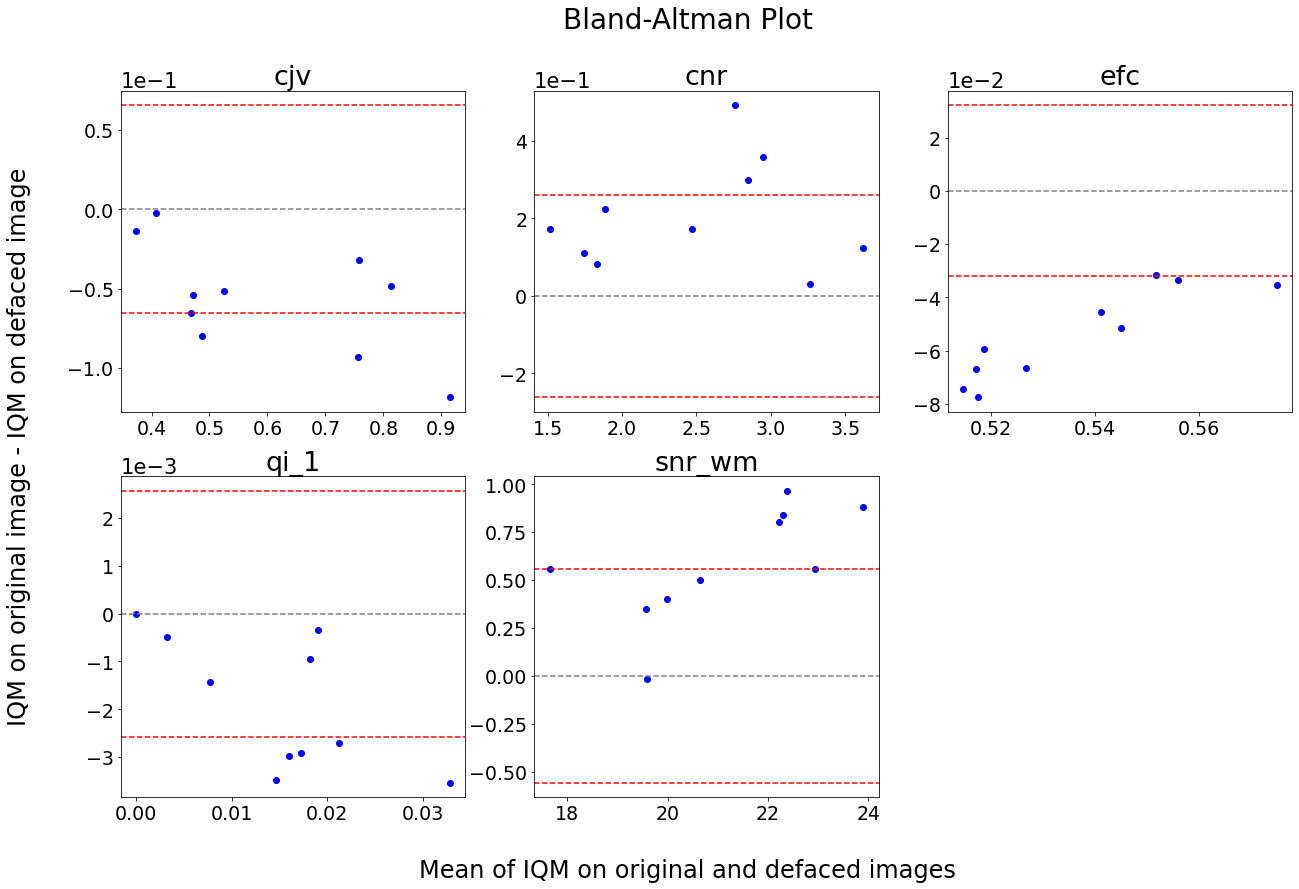

In [5]:
%matplotlib inline
def bland_altman_plot_i5(data1,data2,data_label, ax, fontsize, pos_dict=None, offsety=0,\
                        offsetx=1, facecolor=(1.0, 1.0, 1.0, 1.0)):
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = 0 # np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)  # Standard deviation of the difference
    
    ax.scatter(mean, diff, color = 'b')
    ax.set_title(data_label,fontsize = fontsize+4)
    ax.axhline(md, color='gray', linestyle='--')
    ax.axhline(md + 1.96*sd, color='red', linestyle='--')
    ax.axhline(md - 1.96*sd, color='red', linestyle='--')
    ax.tick_params(labelsize=fontsize-4)
    
     # Scientific notation of yaxis
    ax.ticklabel_format(axis='y', style='scientific',scilimits=(-1,1))
    ax.yaxis.offsetText.set_fontsize(fontsize-2)
    ty = ax.yaxis.get_offset_text()
    ty.set_x(offsety)
    ax.ticklabel_format(axis='x', style='scientific',scilimits=(-5,5))
    ax.xaxis.offsetText.set_fontsize(fontsize-2)
    
# IQMS PLOT
fig, axs = plt.subplots(2,3,sharex=False,sharey=False,figsize=(21,13))
fig.suptitle('Bland-Altman Plot',fontsize=28, y = 0.97)
axs[1,2].set_axis_off()

for j,key in enumerate(['cjv','cnr', 'efc', 'qi_1', 'snr_wm']):
    ind = iqms_keys.index(key)
    bland_altman_plot_i5(iqms_original[:,ind], iqms_defaced[:,ind], key, axs[j//3,j%3], fontsize = 23)

fig.text(0.5, 0.04, 'Mean of IQM on original and defaced images', fontsize = 24, ha='center')
fig.text(0.05, 0.5, 'IQM on original image - IQM on defaced image', fontsize = 24, va='center', rotation='vertical')


## T-TESTS

In [7]:
# Test normality of the data
# TEST VALID ONLY FOR N>20 !!!!!
_,p = stats.normaltest(iqms_original, axis = 0)

/home/cprovins/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [4]:
# t-tests ALL

_,pm = stats.ttest_ind(manual_original, manual_defaced, axis=0)
_,pi = stats.ttest_ind(iqms_original, iqms_defaced, axis=0)
print(pm<0.05)
print(pi<0.05)

rm, pmc, _, _ = multipletests(pm, alpha=0.05, method='bonferroni')
ri, pic, _, _ = multipletests(pi, alpha=0.05, method='bonferroni')
print(rm)
print(pic)
print(ri)
ind = np.where(ri == True)[0]
print('Difference is significant after bonferroni correction for {}'.format(iqms_keys[ind[0]]))

#t-tests ONLY 5
ind5 = []
iqms_keys5 = ['cjv', 'cnr', 'efc', 'qi_1', 'snr_wm']
for key in iqms_keys5:
    ind5.append(iqms_keys.index(key))
    
_,pi5 = stats.ttest_ind(iqms_original[:,ind5], iqms_defaced[:,ind5], axis=0)
print(pi5<0.05)
ri5, pi5c, _, _ = multipletests(pi5, alpha=0.05, method='bonferroni')
print(pi5c)
print(ri5)

rw, pw = stats.mannwhitneyu(iqms_original,iqms_defaced,axis=0)
print(pw<0.05)

[False False]
[False False  True False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
[False False]
[1.         1.         0.00224029 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.14237556 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.      

In [9]:
#Compute Cohen's d effect size for the significant IQM
from statistics import mean, stdev
from math import sqrt

cohens_d = (mean(iqms_original[:,ind[0]]) - mean(iqms_defaced[:,ind[0]]))\
    / (sqrt((stdev(iqms_original[:,ind[0]]) ** 2 + stdev(iqms_defaced[:,ind[0]]) ** 2) / 2))

print(cohens_d)

-2.4297216250643894


In [10]:
print(iqms_original.shape)

(10, 61)


## PCA on original and defaced separately

In [11]:

pca_original = PCA(n_components=None)
pca_original.fit(iqms_original.T)
pca_defaced = PCA(n_components=None)
pca_defaced.fit(iqms_defaced.T)

row_ind, col_ind = optimize.linear_sum_assignment((1-np.corrcoef(pca_original.components_, pca_defaced.components_))[10:,:10])
pca_defaced.components_ = pca_defaced.components_[row_ind,:]

mtxo, mtxd, disparity = spatial.procrustes(pca_original.components_[:3,:],pca_defaced.components_[:3,:])
print(mtxo)
print(disparity)

# MANOVA
# Build dataframe
i_o = np.hstack((pca_original.components_[:3,:].T,np.zeros((10,1))))
i_d = np.hstack((pca_defaced.components_[:3,:].T,np.ones((10,1))))
i_merge = np.vstack((i_o,i_d))
print(i_merge.shape)
iqms_df = pd.DataFrame(i_merge, columns = ['pc1', 'pc2', 'pc3', 'Defaced'])

# Run MANOVA
maov = MANOVA.from_formula('pc1 + pc2 + pc3 ~ Defaced'.format(dep_var), data=iqms_df)

print(maov.mv_test())

[[ 1.93167261e-01  1.37222041e-01 -2.88019795e-02  1.29858732e-01
   2.40669255e-01  1.42349782e-01  9.94859003e-02  4.00244712e-01
  -4.98897756e-04  1.05916647e-01]
 [-1.43054539e-02 -1.37393617e-01  3.14868668e-01 -2.10704658e-01
  -1.83475592e-01 -1.77194833e-01  6.10012078e-02 -1.40828039e-01
  -2.67317744e-01  1.03146440e-01]
 [-1.78861808e-01  1.71576029e-04 -2.86066689e-01  8.08459266e-02
  -5.71936627e-02  3.48450514e-02 -1.60487108e-01 -2.59416674e-01
   2.67816642e-01 -2.09063087e-01]]
2.8325432455450894e-31
(20, 4)


NameError: name 'dep_var' is not defined

## PCA on original and defaced together BASED ON THOSE 10 SUBJECTS

P-values of t-test : 0.5563519130948751
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9749 5.0000 14.0000  0.0721 0.9955
         Pillai's trace 0.0251 5.0000 14.0000  0.0721 0.9955
 Hotelling-Lawley trace 0.0257 5.0000 14.0000  0.0721 0.9955
    Roy's greatest root 0.0257 5.0000 14.0000  0.0721 0.9955
------------------------------------------------------------
                                                            
------------------------------------------------------------
        Defaced         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9510 5.0000 14.0000  0.1442 0.9786
         Pillai's trace 0.0490 5.0000 14.0000  0.1442 0.9786
 H

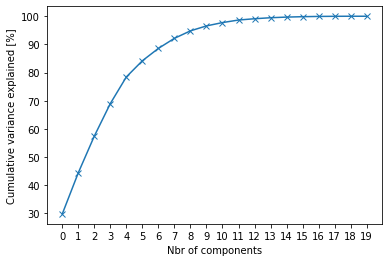

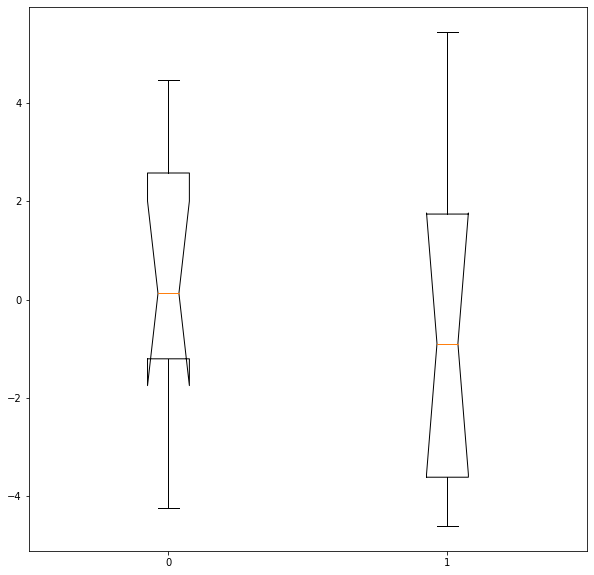

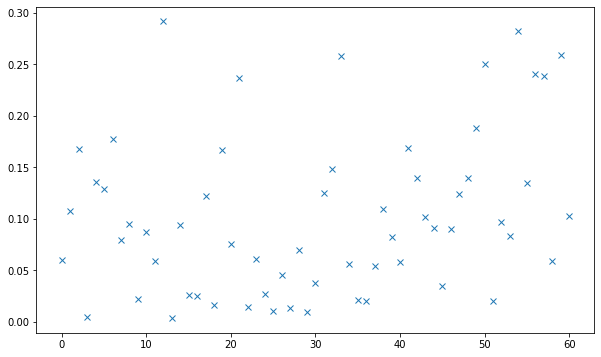

In [12]:

iqms_cat = np.vstack((iqms_original, iqms_defaced))
pca = PCA(n_components=None)
# Z-score so that each IQMs live in the same range of value
iqms_cat_z = stats.zscore(iqms_cat,axis=0)
pca.fit(iqms_cat_z) #n_samples x n_features
basis = pca.components_[:5,:]
projected_iqms = np.matmul(iqms_cat_z,basis.T)

#Plot cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100), '-x')
plt.ylabel('Cumulative variance explained [%]')
plt.xlabel('Nbr of components')
plt.xticks(list(range(0,pca.explained_variance_ratio_.size)))

# T-test 
_, p = stats.ttest_ind(projected_iqms[:10,0], projected_iqms[10:,0], axis=0)
fig, ax = plt.subplots(1,sharex=False,sharey=False,figsize=(10,10))
plt.boxplot(projected_iqms[:10,1],'bo',positions=[0])
plt.boxplot(projected_iqms[10:,1],'ro',positions=[1])
print('P-values of t-test : {}'.format(p))

# MANOVA
deface_bool = np.zeros((20,1))
deface_bool[10:,:]+=1
d = np.hstack((projected_iqms,deface_bool))

dep_var = ''
column_names = []
for p in range(0,projected_iqms.shape[1]):
    dep_var += 'PC{} +'.format(p+1)
    column_names.append('PC{}'.format(p+1))
dep_var = dep_var[:-2]
    
projected_iqms_df = pd.DataFrame(d, columns = column_names + ['Defaced'])
maov = MANOVA.from_formula('{} ~ Defaced'.format(dep_var), data=projected_iqms_df)

print(maov.mv_test())

fig = plt.figure(figsize=(10,6))
plt.plot(abs(pca.components_[4,:]),'x')
#plt.yscale('log')

pc1 = pca.components_[0,:]
ind = np.where(abs(pca.components_[1,:])>10**-4)[0]
print('The significantly different PC is predominantly contributed to by {} with weights of respectively {}'.format(np.array(iqms_keys)[ind], pc1[ind]))

In [ ]:
print(api.shape)
print(pca.components_.shape)
print(iqms_cat_z.shape)

## PCA on original and defaced together BASED ON API

(20, 5)
(5, 61)
P-values of t-test : [0.55635191 0.49116241 0.89427749 0.92838518 0.88382807]
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9749 5.0000 14.0000  0.0721 0.9955
         Pillai's trace 0.0251 5.0000 14.0000  0.0721 0.9955
 Hotelling-Lawley trace 0.0257 5.0000 14.0000  0.0721 0.9955
    Roy's greatest root 0.0257 5.0000 14.0000  0.0721 0.9955
------------------------------------------------------------
                                                            
------------------------------------------------------------
        Defaced         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9510 5.0000 14.0000  0.1442 0.9786
         

"pc1 = pca.components_[0,:]\nind = np.where(abs(pc1)>10**-4)[0]\nprint('The significantly different PC is predominantly contributed to by {} with weights of respectively {}'.format(np.array(iqms_keys)[ind], pc1[ind]))"

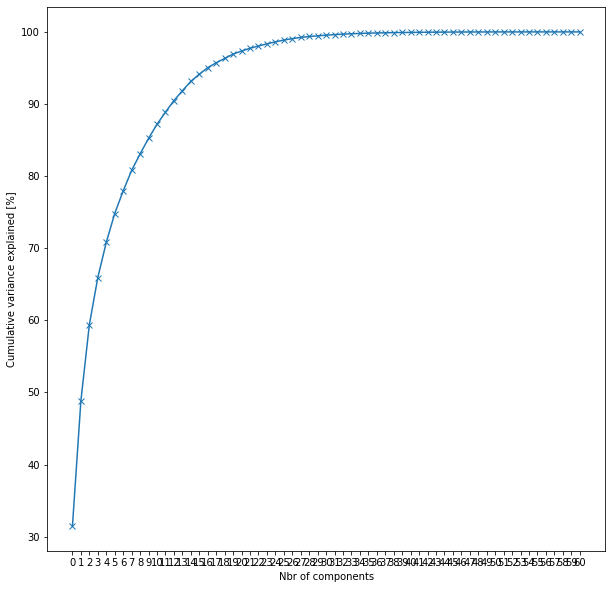

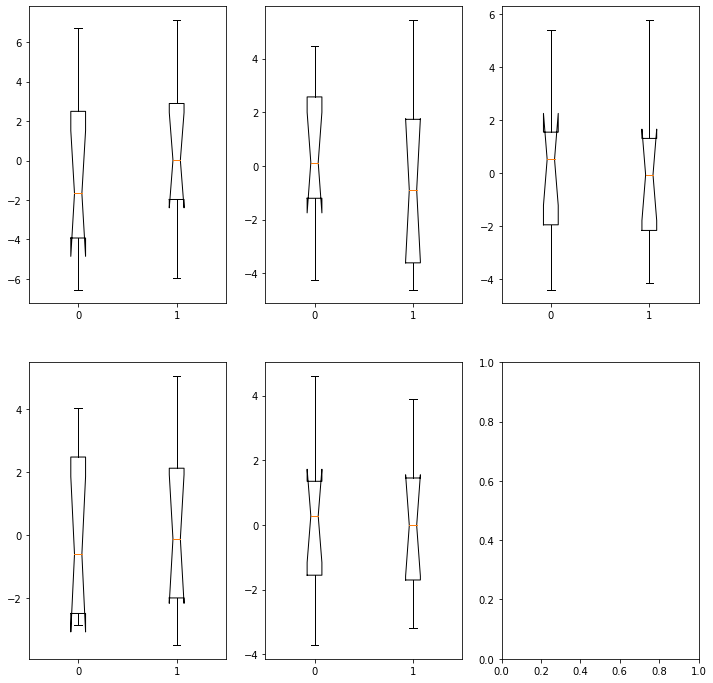

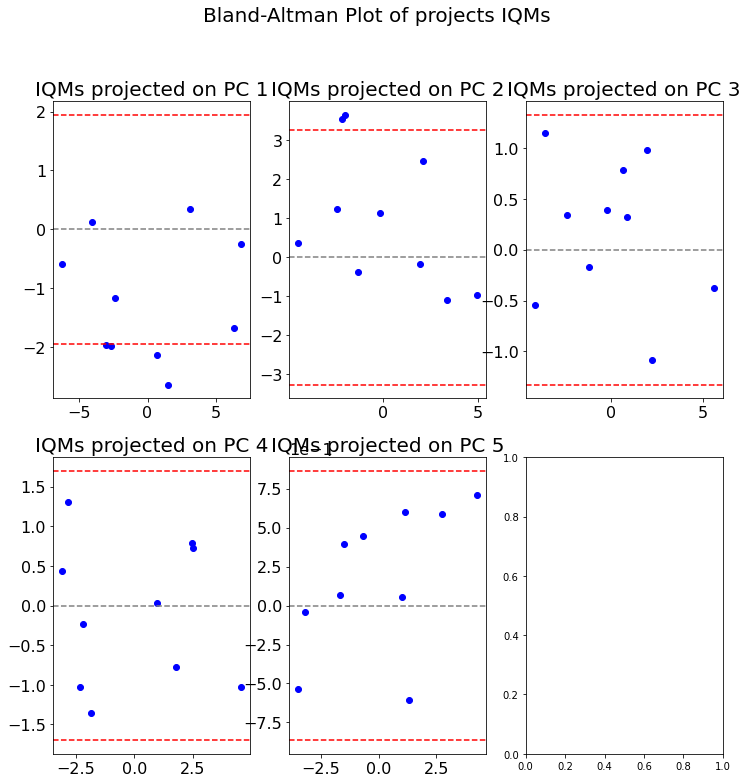

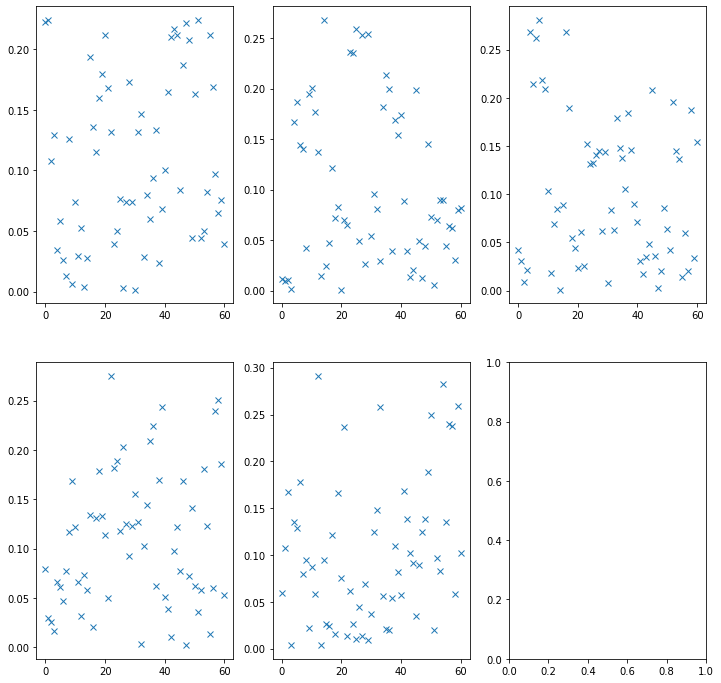

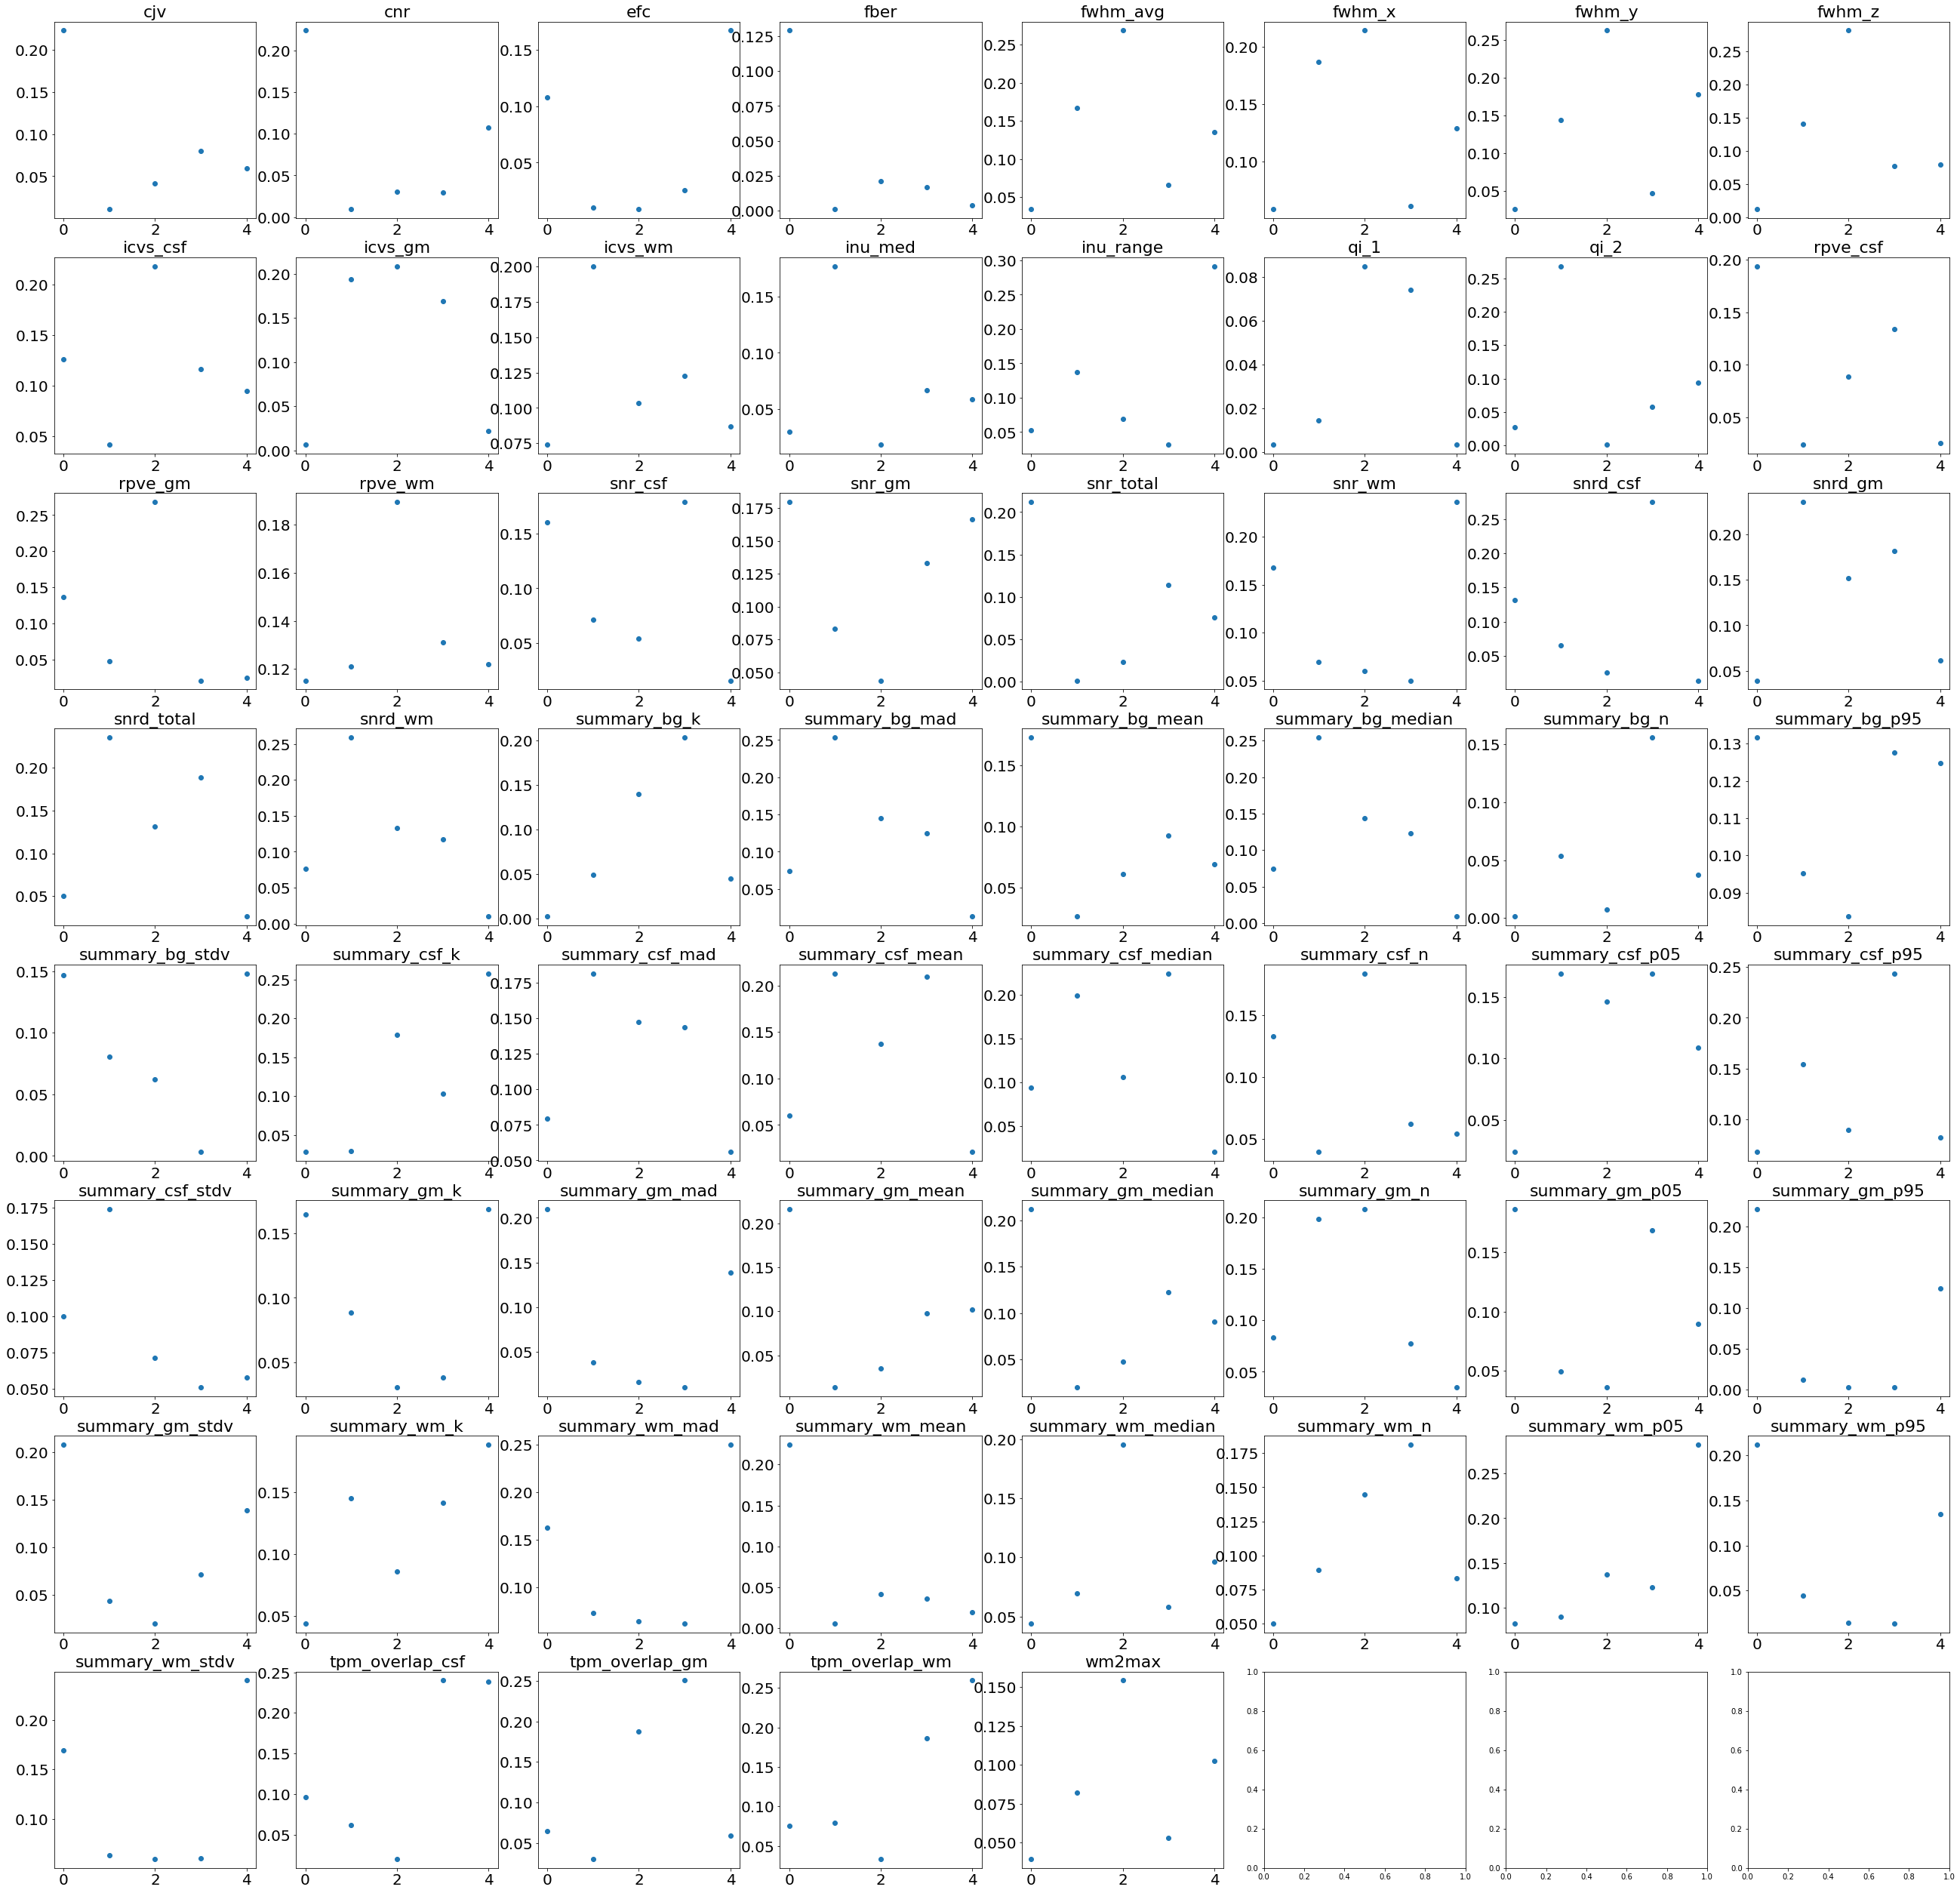

In [13]:
pca = PCA(n_components=None)
# Z-score so that each IQMs live in the same range of value
api_z = stats.zscore(api,axis=0)
pca.fit(api_z) #n_samples x n_features
projected_iqms = np.matmul(iqms_cat_z,basis.T)
print(projected_iqms.shape)
print(basis.shape)

#Plot cumulative variance explained
fig = plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100), '-x')
plt.ylabel('Cumulative variance explained [%]')
plt.xlabel('Nbr of components')
plt.xticks(list(range(0,pca.explained_variance_ratio_.size)))

# T-test 
_, p = stats.ttest_ind(projected_iqms[:10,:], projected_iqms[10:,:], axis=0)
print('P-values of t-test : {}'.format(p))

#BOXPLOT
fig, axs = plt.subplots(2,3,sharex=False,sharey=False,figsize=(12,12))
for k in range(basis.shape[0]):
    axs[k//3,k%3].boxplot(projected_iqms[:10,k],'bo',positions=[0])
    axs[k//3,k%3].boxplot(projected_iqms[10:,k],'ro',positions=[1])
    
#BLAND-ALTMAN
fig, axs = plt.subplots(2,3,sharex=False,sharey=False,figsize=(12,12))
fig.suptitle('Bland-Altman Plot of projects IQMs',fontsize=20, y=0.99)
for k in range(basis.shape[0]):
    bland_altman_plot_i(projected_iqms[:10,k], projected_iqms[10:,k], 'IQMs projected on PC {}'.format(k+1), axs[k//3,k%3], fontsize = 18)
    
# MANOVA
deface_bool = np.zeros((20,1))
deface_bool[10:,:]+=1
d = np.hstack((projected_iqms,deface_bool))

dep_var = ''
column_names = []
for p in range(0,projected_iqms.shape[1]):
    dep_var += 'PC{} +'.format(p+1)
    column_names.append('PC{}'.format(p+1))
dep_var = dep_var[:-2]
    
projected_iqms_df = pd.DataFrame(d, columns = column_names + ['Defaced'])
maov = MANOVA.from_formula('{} ~ Defaced'.format(dep_var), data=projected_iqms_df)

print(maov.mv_test())

fig, axs = plt.subplots(2,3,sharex=False,sharey=False,figsize=(12,12))
for k in range(basis.shape[0]):
    axs[k//3,k%3].plot(abs(basis[k,:]),'x')
#plt.yscale('log')

fig, axs = plt.subplots(8,8,sharex=False,sharey=False,figsize=(45,45))
for k in range(basis.shape[1]):
    ax = axs[k//8,k%8]
    ax.plot(abs(basis[:,k]),'o')
    ax.set_title(iqms_keys[k],fontsize = 22)
    ax.tick_params(labelsize=20)

"""pc1 = pca.components_[0,:]
ind = np.where(abs(pc1)>10**-4)[0]
print('The significantly different PC is predominantly contributed to by {} with weights of respectively {}'.format(np.array(iqms_keys)[ind], pc1[ind]))"""

In [14]:
print(api_z.shape)

(775, 61)


## MANOVA FULL DATA

In [5]:

# Build dataframe
i_o = np.hstack((iqms_original[:,ind5],np.zeros((10,1))))
i_d = np.hstack((iqms_defaced[:,ind5],np.ones((10,1))))
print(i_o.shape)
print(i_d.shape)
i_merge = np.vstack((i_o,i_d))
print(i_merge.shape)
iqms_df = pd.DataFrame(i_merge, columns = iqms_keys5 + ['Defaced'])
print(iqms_keys)
#iqms_df.drop('summary_bg_p05',axis=1)

# Run MANOVA
dep_var = '' 
for key in iqms_keys5:
    dep_var += '{} +'.format(key)
dep_var = dep_var[:-2]

maov = MANOVA.from_formula('{} ~ Defaced'.format(dep_var), data=iqms_df)

print(maov.mv_test())


(10, 6)
(10, 6)
(20, 6)
['cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z', 'icvs_csf', 'icvs_gm', 'icvs_wm', 'inu_med', 'inu_range', 'qi_1', 'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm', 'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm', 'summary_bg_k', 'summary_bg_mad', 'summary_bg_mean', 'summary_bg_median', 'summary_bg_n', 'summary_bg_p95', 'summary_bg_stdv', 'summary_csf_k', 'summary_csf_mad', 'summary_csf_mean', 'summary_csf_median', 'summary_csf_n', 'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv', 'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean', 'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95', 'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean', 'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm_p95', 'summary_wm_stdv', 'tpm_overlap_csf', 'tpm_overlap_gm', 'tpm_overlap_wm', 'wm2max']
                    Multivariate linear model
                       

## EVOLUTION PLOT IQMS

In [ ]:
import seaborn as sns
        
fig, axs = plt.subplots(8,8,sharex=False,sharey=False,figsize=(45,45))
fig.suptitle('IQMs evolution before and after defacing',fontsize=32, y = 0.91)
for i,key in enumerate(iqms_keys):
    ax = axs[i//8,i%8]
    for s in range(0,iqms_original.shape[0]):
        x_values = [0,1]
        y_values = [iqms_original[s,i], iqms_defaced[s,i]]
        ax.plot(x_values, y_values,'-o', color='r')
        ax.set_xticks([0,1])
        ax.set_title(key,fontsize = 24)
        ax.tick_params(labelsize=22)
        ax.ticklabel_format(axis='y', style='scientific',scilimits=(-1,1))
        ax.yaxis.offsetText.set_fontsize(20)
        
fig.text(0.1, 0.5, 'IQMs value', fontsize = 32, va='center', rotation='vertical')
fig.text(0.5, 0.1, 'Metric value on original image (tick 0) versus metric value on defaced image (tick 1)', \
         fontsize = 32, ha='center')

corr = np.corrcoef(iqms_original.T)
corr_df = pd.DataFrame(corr,columns= iqms_keys)
fig, axs = plt.subplots(1,sharex=False,sharey=False,figsize=(10,10))
fig.suptitle('Correlation of IQMs from those 10 subjects', fontsize = 25)
sns.heatmap(corr_df)

corr = np.corrcoef(api.T)
print(corr.shape)
corr_df = pd.DataFrame(corr,columns= iqms_keys)
fig, axs = plt.subplots(1,sharex=False,sharey=False,figsize=(10,10))
fig.suptitle('Correlation of IQMs from API', fontsize = 25)
sns.heatmap(corr_df)

## EVOLUTION PLOT projected IQMs

In [ ]:

fig, axs = plt.subplots(2,3,sharex=False,sharey=False,figsize=(25,15))
fig.suptitle('Principal components evolution before and after defacing',fontsize=24, y=0.95)
for i in range(0, projected_iqms.shape[1]):
    ax = axs[i//3,i%3]
    for s in range(0,10):
        x_values = [0,1]
        y_values = [projected_iqms[s,i], projected_iqms[s+10,i]]
        ax.plot(x_values, y_values,'-o', color='r')
        ax.set_xticks([0,1])
        ax.set_xticklabels(["Non-defaced","Defaced"])
        ax.set_title('IQMs project on principal component {}'.format(i+1),fontsize = 24)
        ax.tick_params(labelsize=22)
        ax.set_xlim([-0.1,1.1])
        
fig.text(0.08, 0.5, 'IQMs value', fontsize = 26, va='center', rotation='vertical')